In [30]:
import numpy as np 
import pandas as pd 
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [31]:
df1 = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Retail%20Transaction%20Data/Retail_Data_Response.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Retail%20Transaction%20Data/Retail_Data_Transactions.csv", parse_dates=["trans_date"])

In [32]:
df1.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [33]:
df2.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [34]:
df1.describe(include='all')

,customer_id,response
count,6884,6884.000000
unique,6884,NaN
top,CS1112,NaN
freq,1,NaN
mean,NaN,0.093986
std,NaN,0.291831
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [35]:
df2.describe(include="all")

<ipython-input-35-ac60ca0c82f2>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include="all")


,customer_id,trans_date,tran_amount
count,125000,125000,125000.000000
unique,6889,1401,NaN
top,CS4424,2011-07-16 00:00:00,NaN
freq,39,141,NaN
first,NaN,2011-05-16 00:00:00,NaN
last,NaN,2015-03-16 00:00:00,NaN
mean,NaN,NaN,64.991912
std,NaN,NaN,22.860006
min,NaN,NaN,10.000000
25%,NaN,NaN,47.000000


In [36]:
print(df2['trans_date'].min())
print(df2['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [37]:
sd = dt.datetime(2015,3,17)
df2['recent']= sd - df2['trans_date']
df2['recent'].astype('timedelta64[D]')
df2['recent']=df2['recent'] / np.timedelta64(1, 'D')
df2.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [38]:
data_rfm = df2.groupby('customer_id').agg({'recent': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x),               # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

data_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)
rfm = data_rfm.reset_index()
rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [39]:
rfm.describe(include='all')

,customer_id,recency,frequency,monetary_value
count,6889,6889.000000,6889.000000,6889.000000
unique,6889,NaN,NaN,NaN
top,CS1112,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,81.538249,18.144869,1179.269705
std,NaN,85.382526,5.193014,465.832609
min,NaN,1.000000,4.000000,149.000000
25%,NaN,23.000000,14.000000,781.000000
50%,NaN,54.000000,18.000000,1227.000000
75%,NaN,112.000000,22.000000,1520.000000


In [40]:
label = df1.groupby('response').agg({'customer_id': lambda x: len(x)})
label.head()

,customer_id
response,
0,6237
1,647


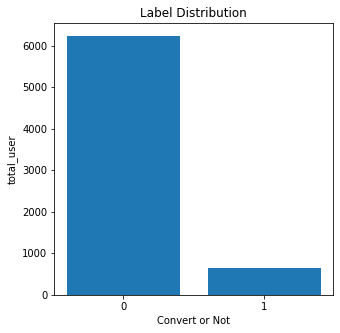

In [41]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label['customer_id'])
plt.xticks(label.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [42]:
dataset = pd.merge(df1,rfm)
dataset.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [43]:
minority_class_len = len(dataset[dataset['response'] == 1])
minority_index_list = dataset[dataset['response'] == 1].index
print(minority_index_list)

Int64Index([   2,    3,    4,    6,   23,   29,   30,   31,   33,   36,
            ...
            6428, 6464, 6475, 6528, 6595, 6645, 6728, 6738, 6788, 6854],
           dtype='int64', length=647)


In [44]:
majority_class_len = len(dataset[dataset['response'] == 0])
majority_index_list = dataset[dataset['response'] == 0].index
print(majority_index_list)

Int64Index([   0,    1,    5,    7,    8,    9,   10,   11,   12,   13,
            ...
            6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883],
           dtype='int64', length=6237)


In [45]:
random_majority = np.random.choice(majority_index_list,
                                   minority_class_len,
                                   replace = False)
under_sample_indexlist = np.concatenate([random_majority,minority_index_list])
under_sample = dataset.loc[under_sample_indexlist]
under_sample.reset_index(drop=True, inplace=True)
under_sample.head()

,customer_id,response,recency,frequency,monetary_value
0,CS2704,0,42.0,20,1462
1,CS3163,0,64.0,31,2413
2,CS3286,0,78.0,18,1150
3,CS2017,0,170.0,20,1286
4,CS8547,0,25.0,11,488


In [46]:
label_us = under_sample.groupby('response').agg({'customer_id': lambda x: len(x)})
label_us.head()

,customer_id
response,
0,647
1,647


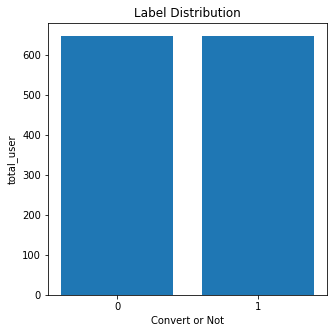

In [47]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_us['customer_id'])
plt.xticks(label_us.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [48]:
from sklearn.utils import resample
y = dataset.response
X = dataset.drop('response', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
X = pd.concat([X_train, y_train], axis=1)
X.head()

,customer_id,recency,frequency,monetary_value,response
2634,CS3746,74.0,19,1475,0
4905,CS6017,3.0,28,2109,0
2436,CS3548,38.0,19,1398,0
1875,CS2987,89.0,20,1508,0
5717,CS7832,104.0,20,905,0


In [49]:
not_order = X[X.response==0]
order = X[X.response==1]

order_upsampled = resample(order,
                          replace=True, # sample with replacement
                          n_samples=len(not_order), # match number in majority class
                          random_state=27) # reproducible results

upsampled = pd.concat([not_order, order_upsampled])
upsampled.reset_index(drop=True, inplace=True)
upsampled.head()

,customer_id,recency,frequency,monetary_value,response
0,CS3746,74.0,19,1475,0
1,CS6017,3.0,28,2109,0
2,CS3548,38.0,19,1398,0
3,CS2987,89.0,20,1508,0
4,CS7832,104.0,20,905,0


In [50]:
label_os = upsampled.groupby('response').agg({'customer_id': lambda x: len(x)})
label_os.head()

,customer_id
response,
0,4676
1,4676


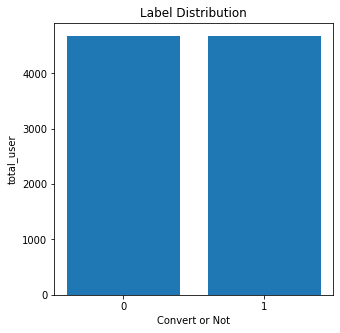

In [51]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_os['customer_id'])
plt.xticks(label_os.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

In [52]:
x = under_sample.drop(columns=['response','customer_id'])
y = under_sample['response']
identifier = under_sample['customer_id']

for i in range(0,100):
    skf = StratifiedKFold(n_splits=5, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [53]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,CS2017,1,0
1,CS4538,0,0
2,CS1156,0,0
3,CS3011,0,0
4,CS4299,0,0


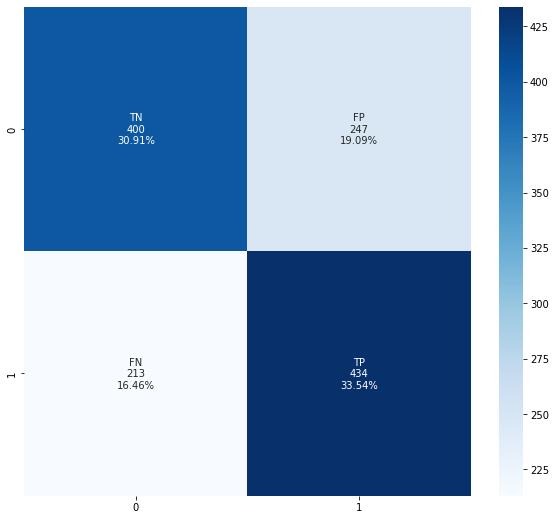

In [54]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

In [55]:
x = upsampled.drop(columns=['response','customer_id'])
y = upsampled['response']
identifier = upsampled['customer_id']


for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
         
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [56]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,CS3548,0,0
1,CS7714,0,0
2,CS2660,0,0
3,CS1112,0,0
4,CS1830,0,0


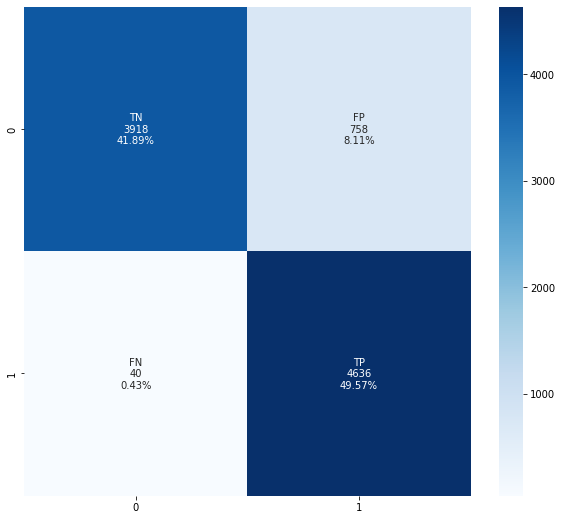

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

,id,pred,exp
0,CS3548,0.133697,0
1,CS7714,0.000129,0
2,CS2660,0.022364,0
3,CS1112,0.188250,0
4,CS1830,0.195577,0


In [57]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

x = upsampled.drop(columns=['response','customer_id'])
y = upsampled['response']
identifier = upsampled['customer_id']

for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict_proba(x.loc[test_index])[:,1]
    
    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y} 
prob_score = pd.DataFrame(data=result)
prob_score.head()

In [58]:
prob_score.to_csv('xgboost_propensity_score.csv',index=False)